In [1]:
import os
import openai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

openai.api_key = os.environ['OPENAI_API_KEY']
np.set_printoptions(precision=3, suppress=True)


def get_embedding(text):
    '''Compute GPT3-embedding for a given text string'''
    result = openai.Embedding.create(input=text, model='text-embedding-ada-002')
    return np.array(result.data[0].embedding)

In [2]:
people = pd.read_csv('./data/people.csv')
messages = pd.read_csv('./data/messages.csv')
images = pd.read_csv('./data/images.csv')

In [3]:
for df in [people, messages, images]:
    df['embedding'] = df['content'].apply(get_embedding)

    # offset each group by it's center
    emb_center = df['embedding'].mean()
    df['embedding'] = df['embedding'].apply(lambda emb: emb - emb_center)

### Visualize embeddings

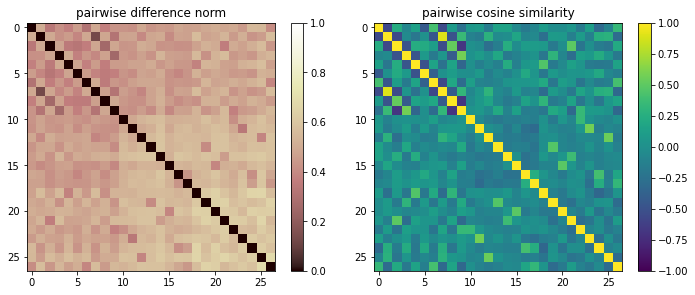

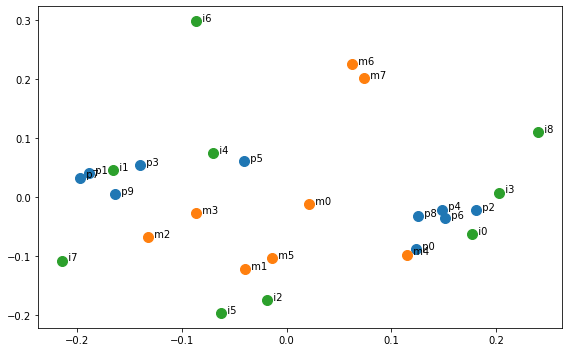

In [4]:
embs = people.embedding.tolist() + messages.embedding.tolist() + images.embedding.tolist()
fig, ax = plt.subplots(1, 2, figsize=(10,4))

# plot embedding difference norm
emb_norm_diff = [[np.linalg.norm(e1-e2) for e2 in embs] for e1 in embs]
im0 = ax[0].imshow(emb_norm_diff, cmap='pink', vmin=0., vmax=1.)
ax[0].set_title('pairwise difference norm')
ax[0].grid(False)
plt.colorbar(im0, ax=ax[0])

# plot embedding cosine similarity
emb_cossim = [[np.dot(e1,e2)/(np.linalg.norm(e1)*np.linalg.norm(e2)) for e2 in embs] for e1 in embs]
im1 = ax[1].imshow(emb_cossim, cmap='viridis', vmin=-1., vmax=1.)
ax[1].set_title('pairwise cosine similarity')
ax[1].grid(False)
plt.colorbar(im1, ax=ax[1])

plt.tight_layout()
plt.show()

# plot embedding pca
emb_pca = PCA(n_components=2).fit_transform(embs)
people_pca, messages_pca, images_pca = np.split(emb_pca, [len(people),-len(images)])
fig, ax = plt.subplots(figsize=(8,5))
# plot people pca
ax.scatter(people_pca[:,0], people_pca[:,1], s=100)
for ind, pnt in enumerate(people_pca):
    ax.annotate(f'  p{ind}', pnt)
# plot messages pca
ax.scatter(messages_pca[:,0], messages_pca[:,1], s=100)
for ind, pnt in enumerate(messages_pca):
    ax.annotate(f'  m{ind}', pnt)
# plot images pca
ax.scatter(images_pca[:,0], images_pca[:,1], s=100)
for ind, pnt in enumerate(images_pca):
    ax.annotate(f'  i{ind}', pnt)
plt.tight_layout()
plt.show()

### Compute recommendations

In [5]:
def softmax(x, temp=1.):
    """Compute row-wise softmax of a matrix x"""
    z = np.array(x)
    z -= z.max(axis=1, keepdims=True)
    z = np.exp(z / temp)
    z /= z.sum(axis=1, keepdims=True)
    return z


def get_recs(df1, df2, temp=.1, k=3):
    """Normalize df1-df2 proximity and return k best/worst recommendations"""
    neg_norms = [[-np.linalg.norm(e1-e2) for e2 in df2.embedding] for e1 in df1.embedding]
    probs = softmax(neg_norms, temp=temp)
    print(f'probability distribution:\n{probs}')
    
    # show k best/worst recommendations for each element
    inds = probs.argsort(axis=1)
    for i in range(len(df1)):
        print('\n========================\n')
        print(df1.loc[i].content)
        
        # k best recommendations
        print()
        for j in range(k):
            l = inds[i][~j]
            print(f'#{l} ({100*probs[i][l]:.0f}%): {df2.loc[l].content}')

        # k worst recommendations
        print()
        for j in range(k):
            l = inds[i][j]
            print(f'#{l} ({100*probs[i][l]:.0f}%): {df2.loc[l].content}')

In [6]:
# people--images
get_recs(people, images)

probability distribution:
[[0.121 0.097 0.084 0.109 0.091 0.156 0.056 0.059 0.228]
 [0.053 0.123 0.106 0.07  0.162 0.086 0.196 0.153 0.051]
 [0.103 0.063 0.077 0.314 0.076 0.106 0.068 0.043 0.15 ]
 [0.056 0.206 0.069 0.049 0.168 0.134 0.177 0.08  0.061]
 [0.302 0.061 0.07  0.122 0.131 0.073 0.062 0.046 0.132]
 [0.065 0.126 0.089 0.109 0.149 0.142 0.177 0.067 0.077]
 [0.154 0.061 0.111 0.103 0.078 0.098 0.07  0.053 0.274]
 [0.049 0.12  0.081 0.061 0.185 0.121 0.187 0.148 0.048]
 [0.208 0.07  0.069 0.141 0.088 0.118 0.069 0.088 0.149]
 [0.057 0.154 0.105 0.047 0.27  0.132 0.115 0.073 0.047]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#8 (23%): Young adult African American man walking his dog in the park.
#5 (16%): Person coloring in a coloring book with crayons.
#0 (12%): Young adult Indian man playing guitar and smiling.

#6 (6%): Senior white woman biking in the park and look

In [7]:
# messages--images
get_recs(messages, images)

probability distribution:
[[0.095 0.062 0.097 0.075 0.312 0.117 0.088 0.058 0.097]
 [0.076 0.062 0.047 0.053 0.106 0.499 0.054 0.047 0.056]
 [0.08  0.087 0.059 0.058 0.095 0.082 0.071 0.412 0.056]
 [0.084 0.388 0.062 0.062 0.089 0.108 0.071 0.073 0.064]
 [0.111 0.084 0.1   0.305 0.089 0.088 0.072 0.063 0.087]
 [0.069 0.073 0.349 0.1   0.091 0.116 0.07  0.056 0.077]
 [0.097 0.076 0.051 0.082 0.124 0.064 0.313 0.047 0.147]
 [0.081 0.089 0.067 0.093 0.117 0.058 0.2   0.052 0.243]]


Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the perfect escape from screens.

#4 (31%): Young adult asian woman reading a book outside and smiling.
#5 (12%): Person coloring in a coloring book with crayons.
#2 (10%): Person with glasses filling out the newspaper crossword puzzle.

#7 (6%): Person knitting at home next to a basket of yarn.
#1 (6%): Adult white woman rolling dough in the kitchen and smiling.
#3 (7%): Senior hispa

In [8]:
# people--messages
get_recs(people, messages)

probability distribution:
[[0.154 0.169 0.082 0.151 0.121 0.13  0.087 0.105]
 [0.1   0.095 0.22  0.094 0.078 0.208 0.099 0.106]
 [0.135 0.129 0.065 0.078 0.145 0.137 0.156 0.155]
 [0.137 0.17  0.11  0.166 0.056 0.112 0.117 0.131]
 [0.136 0.104 0.108 0.08  0.154 0.112 0.148 0.158]
 [0.127 0.16  0.081 0.095 0.063 0.144 0.196 0.134]
 [0.174 0.109 0.086 0.087 0.09  0.163 0.142 0.149]
 [0.11  0.147 0.227 0.092 0.062 0.166 0.095 0.101]
 [0.124 0.156 0.162 0.088 0.055 0.111 0.174 0.131]
 [0.139 0.156 0.102 0.166 0.064 0.189 0.091 0.093]]


Gender: Male
Age: Young Adult
Race: African American
Lifestyle: Moderate
Likes: Reading, Baking, Watercolor Painting
Dislikes: Weightlifting, Solitaire

#1 (17%): Put down your phone and grab some colored pencils! Coloring books are a fun and creative way to unwind and unleash your inner artist. Let's get coloring!
#0 (15%): Put down your phone and pick up a book! Get lost in a new world, learn something new, or be inspired by a biography. Reading is the pe